# Google Colab Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sklearn-genetic-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 5.8 MB/s eta 0:00:00


# Global constants

## For Google Colab

In [6]:
TRAIN_DATA_CSV = '/content/drive/MyDrive/BTC/data/var_call_opt/training_data/dv_opt_data_mini.csv'
TRAIN_DATA_FULL_CSV = '/content/drive/MyDrive/BTC/data/var_call_opt/training_data/dv_opt_data_full.csv'

## For BTC Server

In [1]:
#!jupyter trust *.ipynb*

In [2]:
ROOT_DIR = '/home/skomlev'

TRAIN_DATA_DIR = ROOT_DIR + '/projects/var_call_opt/data/training_data'
HYPEROPT_MODELS_DIR = ROOT_DIR + '/projects/var_call_opt/models/hyperopt_models'

In [3]:
TRAIN_DATA_MINI_CSV = TRAIN_DATA_DIR + '/dv_opt_data_mini.csv'
TRAIN_DATA_FULL_CSV = TRAIN_DATA_DIR + '/dv_opt_data_full.csv'

# Classes, Methods

In [4]:
import pickle

def save_model(model, path: str):
    pickle.dump(model, open(path, 'wb'))

In [5]:
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.metrics.cluster import pair_confusion_matrix

class ClassEvaluation:
    """
    Class for the evaluation of classification quality
    """
    
    def __init__(self, x_test, y_test, model, is_indel = False):
        if len(x_test) != len(y_test):
            raise ValueError("'x_test' should be the same length as 'y_test'")
        
        full_test = x_test.copy()
        full_test['is_valid'] = y_test
        full_test['prediction'] = model.predict(x_test)
        
        self.full_test: pd.DataFrame = full_test
        
        if is_indel:
            self.test_by_mutation_type = {
                'full': full_test,
                'het_indel': full_test.loc[(full_test['is_indel'] == True) & (full_test['PL_0/1'] == 0),:],
                'homo_indel': full_test.loc[(full_test['is_indel'] == True) & (full_test['PL_0/1'] != 0),:],
                'het_snp': full_test.loc[(full_test['is_indel'] == False) & (full_test['PL_0/1'] == 0),:],
                'homo_snp': full_test.loc[(full_test['is_indel'] == False) & (full_test['PL_0/1'] != 0),:],   
            }
        else:
            self.test_by_mutation_type = {
                'full': full_test,
                'het_indel': full_test.loc[(full_test['ref_alt_diff'] > 0) & (full_test['PL_0/1'] == 0),:],
                'homo_indel': full_test.loc[(full_test['ref_alt_diff'] == 0) & (full_test['PL_0/1'] != 0),:],
                'het_snp': full_test.loc[(full_test['ref_alt_diff'] > 0) & (full_test['PL_0/1'] == 0),:],
                'homo_snp': full_test.loc[(full_test['ref_alt_diff'] == 0) & (full_test['PL_0/1'] != 0),:]
            }
            
        '''
        self.het_indel_test = full_test.loc[(full_test['is_indel'] == True) & (full_test['PL_0/1'] == 0),:]
        self.homo_indel_test = full_test.loc[(full_test['is_indel'] == True) & (full_test['PL_0/1'] != 0),:]
        self.het_snp_test = full_test.loc[(X_test['is_indel'] == False) & (X_test['PL_0/1'] == 0),:]
        self.homo_snp_test = full_test.loc[(X_test['is_indel'] == False) & (X_test['PL_0/1'] != 0),:]
        '''
    
    #def filter_by_mutation_type(mutation_type: str = 'indel_het'):
    
    def calculate_metrics(self, mutation_type_filter='full', round_digits=4) -> dict:
                return {
          f'f1_score_{mutation_type_filter}': round(
              f1_score(
                  self.test_by_mutation_type[mutation_type_filter]['is_valid'],
                  self.test_by_mutation_type[mutation_type_filter]['prediction']),
              round_digits),
          f'precision_{mutation_type_filter}': round(
              precision_score(
                  self.test_by_mutation_type[mutation_type_filter]['is_valid'],
                  self.test_by_mutation_type[mutation_type_filter]['prediction']),
              round_digits),
          f'recall_{mutation_type_filter}': round(
              recall_score(
                  self.test_by_mutation_type[mutation_type_filter]['is_valid'],
                  self.test_by_mutation_type[mutation_type_filter]['prediction']),
              round_digits)
        }
    
    
    def f_score(self, beta = 1):
        return (1 + beta ** 2) * (self.precision * self.recall) / (beta ** 2 * self.precision + self.recall)

    def plot_confusion_mtrix(self, annot=True, cmap='Blues', fmt='d'):
        return sns.heatmap(self.confus_matrix, annot=annot, cmap=cmap, fmt=fmt)

    def metrics_dict(self, round_digits = 3): # should make it possible to pass metrics params via mb dict
        return {
          'jaccard_score': round(self.jaccard_score(), round_digits),
          'f_score': round(self.f_score(), round_digits),
          'fowlkes_mallows_score': round(self.fowlkes_mallows_score(), round_digits)
        }

# Prepare data

## Get data

In [6]:
import pandas as pd

In [7]:
X_full = pd.read_csv(TRAIN_DATA_FULL_CSV)
X_full

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid
0,1,10352,4.0,3,6,3,2,0.333333,0,5,0,1,False
1,1,10389,7.2,3,7,4,2,0.285714,4,2,0,1,False
2,1,13613,13.3,10,5,0,5,1.000000,12,13,0,0,False
3,1,13684,13.8,11,3,0,3,1.000000,13,13,0,0,False
4,1,13813,11.6,9,5,0,5,1.000000,11,12,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4584937,22,50807889,25.1,25,10,0,9,0.900000,25,40,0,0,False
4584938,22,50807905,4.2,4,9,2,7,0.777778,2,14,0,0,False
4584939,22,50807909,4.6,4,10,3,7,0.700000,2,16,0,0,False
4584940,22,50807933,5.5,5,13,10,3,0.230769,3,0,11,0,False


In [8]:
X_mini = pd.read_csv(TRAIN_DATA_MINI_CSV, index_col = 0)
X_mini

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid
3724288,15,34212396,53.6,53,49,18,31,0.632653,53,0,65,0,True
1243739,4,115788034,61.9,60,36,0,36,1.000000,61,63,0,0,True
3423801,13,42972288,35.2,35,32,20,12,0.375000,35,0,59,0,True
1786116,6,55096300,34.2,34,25,15,10,0.400000,34,0,62,0,True
879182,3,90172768,34.2,32,29,16,13,0.448276,34,0,36,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700860,10,12560540,48.1,48,39,20,19,0.487179,48,0,63,0,True
2773554,10,52612545,52.0,52,34,17,17,0.500000,52,0,68,0,True
2285109,8,19190528,47.7,46,31,0,29,0.935484,47,49,0,2,True
3717443,15,30377333,24.6,19,4,0,4,1.000000,24,19,0,0,True


## Train/Test split

In [9]:
# 100 000 samples are 2.18% of the whole dataset
100 * 100000 / 4584942

2.181052671985818

In [10]:
X = X_full

In [11]:
# If using only a part of the dataset
#X = X_mini

In [12]:
features = list(X.columns)
features.remove('is_valid')
features

['CHROM_num',
 'POS',
 'QUAL',
 'GQ',
 'DP',
 'AD_ref',
 'AD_alt',
 'VAF',
 'PL_0/0',
 'PL_0/1',
 'PL_1/1',
 'ref_alt_diff']

* train - for any training. Both for model fitting and hyperopt grid searches
* val - to choose between sets of hyperparameters
* heldout - final evaluation for reporting only!

In [13]:
from sklearn.model_selection import train_test_split

# Separate the test data
X_train, X_test, y_train, y_test = train_test_split(X[features], X['is_valid'], test_size=0.3, shuffle=True, random_state=42)

# Split the remaining data to test and validation
X_val, X_heldout, y_val, y_heldout = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=42)

In [14]:
X_val

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff
1582528,5,125056666,39.8,40,33,13,20,0.606061,39,0,60,0
3597764,14,47695207,34.9,35,30,18,12,0.400000,34,0,56,0
1693449,6,12211736,66.0,60,25,0,25,1.000000,65,60,0,0
3182253,12,19595603,45.8,46,17,6,11,0.647059,45,0,59,0
1842146,6,90605367,29.6,30,19,12,7,0.368421,29,0,61,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3007315,11,49004877,48.6,45,30,0,30,1.000000,48,47,0,2
880902,3,91041121,18.4,18,16,5,11,0.687500,18,28,0,0
1144660,4,54823329,56.6,55,34,0,34,1.000000,56,59,0,0
315616,1,220671856,43.9,44,21,10,11,0.523810,43,0,65,0


## Make mini training set for Grid Search

In [15]:
X_train_5 = X_train.sample(frac=0.05, random_state=42)
X_train_5

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff
4554907,22,34033749,50.6,46,32,9,23,0.718750,50,0,48,0
751018,3,9815830,61.0,59,40,0,40,1.000000,60,62,0,0
4484047,21,28158967,36.3,36,27,11,16,0.592593,36,0,56,0
1197098,4,83665304,48.7,48,31,9,22,0.709677,48,0,54,3
3310659,12,101383832,53.2,47,29,0,29,1.000000,53,48,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2298243,8,26743551,44.8,44,37,0,37,1.000000,44,54,0,0
235018,1,168333684,60.3,57,29,0,29,1.000000,60,59,0,0
1302018,4,150747374,62.4,58,33,0,33,1.000000,62,60,0,0
717429,2,236024319,39.9,40,36,18,18,0.500000,39,0,60,0


In [16]:
train_5_indexes = X_train_5.index
train_5_indexes

Int64Index([4554907,  751018, 4484047, 1197098, 3310659, 3659194, 4097620,
            1422645, 1771485,   50152,
            ...
            1411241, 2733939, 4234918, 3049910, 3599772, 2298243,  235018,
            1302018,  717429,   15822],
           dtype='int64', length=160473)

In [17]:
y_train_5 = y_train[train_5_indexes]
y_train_5

4554907    True
751018     True
4484047    True
1197098    True
3310659    True
           ... 
2298243    True
235018     True
1302018    True
717429     True
15822      True
Name: is_valid, Length: 160473, dtype: bool

In [18]:
X_val_5 = X_val.sample(frac=0.05, random_state=42)
X_val_5

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff
1576532,5,121402572,46.4,46,29,17,12,0.413793,46,0,99,0
3674294,14,94369623,53.5,53,44,0,44,1.000000,53,59,0,0
510664,2,98071289,41.9,42,35,16,19,0.542857,41,0,57,0
1003882,3,172961093,5.5,6,19,12,7,0.368421,4,0,29,0
640335,2,187350565,42.5,42,25,13,12,0.480000,42,0,67,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3627933,14,66359060,47.3,47,41,22,19,0.463415,47,0,66,2
4175537,18,47568260,62.9,60,25,0,25,1.000000,62,63,0,0
82697,1,55331615,36.5,36,41,20,21,0.512195,36,0,66,0
4266414,19,15600980,18.8,18,9,0,9,1.000000,18,29,0,0


# Genetic Hyperparameter Optimization

## Gradient Boosting

In [19]:
import matplotlib.pyplot as plt
import xgboost as xgb

import sklearn

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold

2023-06-06 02:35:58.640720: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 02:35:58.681258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 02:35:59.304670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Evolver 1

In [20]:
cv3 = StratifiedKFold(n_splits=3, shuffle=True)

In [21]:
xgb_gene_space1 = {
    'booster': Categorical(['gbtree','gblinear','dart']),
    
    'max_depth': Integer(20, 150),
    'max_leaves': Integer(2, 35),
    'min_child_weight': Integer(0, 20),
    'n_estimators': Integer(150, 300),
    
    'gamma': Continuous(5, 25),
    'learning_rate': Continuous(0, 1),
    'reg_alpha': Continuous(0, 1),
    'reg_lambda': Continuous(0, 1),
    'colsample_bytree': Continuous(0.5, 1)
}

In [22]:
gene_xgb1 = xgb.XGBClassifier(n_jobs = 30)

In [23]:
evolver_xgb1 = GASearchCV(estimator=gene_xgb1,
                               cv=cv3,
                               scoring='f1',
                               population_size=10,
                               generations=10,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=xgb_gene_space1,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [ ]:
evolver_xgb1.fit(X_train_5, y_train_5)

In [35]:
evolver_xgb1.best_params_

{'booster': 'gbtree',
 'max_depth': 44,
 'max_leaves': 3,
 'min_child_weight': 4,
 'n_estimators': 292,
 'gamma': 10.703179862757292,
 'learning_rate': 0.23766071172584569,
 'reg_alpha': 0.8373640727665222,
 'reg_lambda': 0.9728444930418584,
 'colsample_bytree': 0.5329439139347303}

In [ ]:
save_model(evolver_xgb1, 'evolver_xgb1.sav')

In [36]:
xgb_opt1 = evolver_xgb1.best_estimator_
xgb_opt1

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5329439139347303, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10.703179862757292, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23766071172584569, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=44, max_leaves=3,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=292, n_jobs=30, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [37]:
xgb_opt1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5329439139347303, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10.703179862757292, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.23766071172584569, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=44, max_leaves=3,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=292, n_jobs=30, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [38]:
preds_xgb_opt1 = xgb_opt1.predict(X_val)

In [39]:
f1_score(y_val, preds_xgb_opt1)

0.9662504865763039

### Evolver 2

In [ ]:
evolver_xgb1.best_params_

In [ ]:
evolver_xgb1.hof

In [ ]:
'exact, approx, hist, gpu_hist'.split(',')

['exact', ' approx', ' hist', ' gpu_hist']

In [ ]:
xgb_gene_space2 = {
    'tree_method': Categorical(['exact', 'approx', 'hist', 'gpu_hist']),
    'scale_pos_weight': Continuous(0, 1),
    
    'max_depth': Integer(55, 180),
    'max_leaves': Integer(8, 35),
    'min_child_weight': Integer(10, 30),
    'n_estimators': Integer(150, 230),
    
    'gamma': Continuous(10, 20),
    'learning_rate': Continuous(0.2, 0.9),
    'reg_alpha': Continuous(0.25, 0.5),
    'reg_lambda': Continuous(0.4, 0.7),
    'colsample_bytree': Continuous(0.8, 1)
}

In [ ]:
gene_xgb2 = xgb.XGBClassifier(booster = 'dart')

In [ ]:
evolver_xgb2 = GASearchCV(estimator=gene_xgb2,
                               cv=cv4,
                               scoring='f1',
                               population_size=10,
                               generations=10,
                               tournament_size=4,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=xgb_gene_space2,
                               criteria='max',
                               algorithm='eaMuCommaLambda',
                               n_jobs=15,
                               verbose=True,
                               keep_top_k=6)

In [ ]:
evolver_xgb2.fit(X_train_5, y_train_5)

/home/skomlev/.local/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/skomlev/.local/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs

1  	20    	0.953425	0.000160027	0.953734   	0.95325    


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


2  	17    	0.953722	0.000370828	0.954373   	0.953391   


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

3  	19    	0.954348	0.000298538	0.954701   	0.953626   


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

4  	19    	0.954803	0.000184113	0.955091   	0.954574   


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


5  	17    	0.954851	0.000169517	0.955107   	0.954545   


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


6  	16    	0.954934	0.000144203	0.955118   	0.954632   


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a me

7  	20    	0.955082	8.80932e-05	0.955179   	0.95489    


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


8  	18    	0.955057	6.74095e-05	0.955133   	0.954946   
10 	18    	0.95508 	6.62337e-05	0.955217   	0.954938   


GASearchCV(algorithm='eaMuCommaLambda', crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
           estimator=XGBClassifier(base_score=None, booster='dart',
                                   callbacks=None, colsample_bylevel=None,
                                   colsample_bynode=None,
                                   colsample_bytree=0.8414378980220896,
                                   early_stopping_rounds=None,
                                   enable_categorical=False, eval_metric=None,
                                   fea...
                       'reg_alpha': <sklearn_genetic.space.space.Continuous object at 0x7f42775fdc70>,
                       'reg_lambda': <sklearn_genetic.space.space.Continuous object at 0x7f42775fd9a0>,
                       'scale_pos_weight': <sklearn_genetic.space.space.Continuous object at 0x7f4284787ee0>,
                       'tree_method': <sklearn_genetic.space.space.Categorical object at 0x7f4419f0fcd0>},
           population_size=10, return_train_score=True, scoring='f1',
           tournament_size=4)

In [ ]:
evolver_xgb2.best_estimator_

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8414378980220896, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10.760334366371987, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2443591369209849, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=74, max_leaves=33,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              n_estimators=230, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
evolver_xgb2.hof

{0: {'tree_method': 'gpu_hist',
  'scale_pos_weight': 0.8347808150182244,
  'max_depth': 74,
  'max_leaves': 33,
  'min_child_weight': 12,
  'n_estimators': 230,
  'gamma': 10.760334366371987,
  'learning_rate': 0.2443591369209849,
  'reg_alpha': 0.32112497611773394,
  'reg_lambda': 0.46742053311022985,
  'colsample_bytree': 0.8414378980220896},
 1: {'tree_method': 'gpu_hist',
  'scale_pos_weight': 0.8347808150182244,
  'max_depth': 74,
  'max_leaves': 33,
  'min_child_weight': 12,
  'n_estimators': 230,
  'gamma': 10.760334366371987,
  'learning_rate': 0.2443591369209849,
  'reg_alpha': 0.32112497611773394,
  'reg_lambda': 0.5565767803293862,
  'colsample_bytree': 0.9382564185122233},
 2: {'tree_method': 'gpu_hist',
  'scale_pos_weight': 0.8347808150182244,
  'max_depth': 74,
  'max_leaves': 33,
  'min_child_weight': 12,
  'n_estimators': 230,
  'gamma': 10.760334366371987,
  'learning_rate': 0.2551351058668089,
  'reg_alpha': 0.35182287880174284,
  'reg_lambda': 0.5565767803293862,
 

In [ ]:
xgb_opt2 = evolver_xgb2.best_estimator_
xgb_opt2

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8414378980220896, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10.760334366371987, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2443591369209849, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=74, max_leaves=33,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              n_estimators=230, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
xgb_opt2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8414378980220896, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=10.760334366371987, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2443591369209849, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=74, max_leaves=33,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              n_estimators=230, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
preds_xgb_opt2 = xgb_opt2.predict(X_val)

In [ ]:
f1_score(y_val, preds_xgb_opt2)

0.957228554338908

In [ ]:
import pickle

filename = 'evolver_xgb2.sav'
pickle.dump(evolver_xgb2, open(filename, 'wb'))

TypeError: cannot pickle 'module' object

#### Visualize

/home/skomlev/.local/lib/python3.8/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


<Axes: title={'center': 'Fitness average evolution over generations'}, xlabel='generations', ylabel='fitness (score)'>

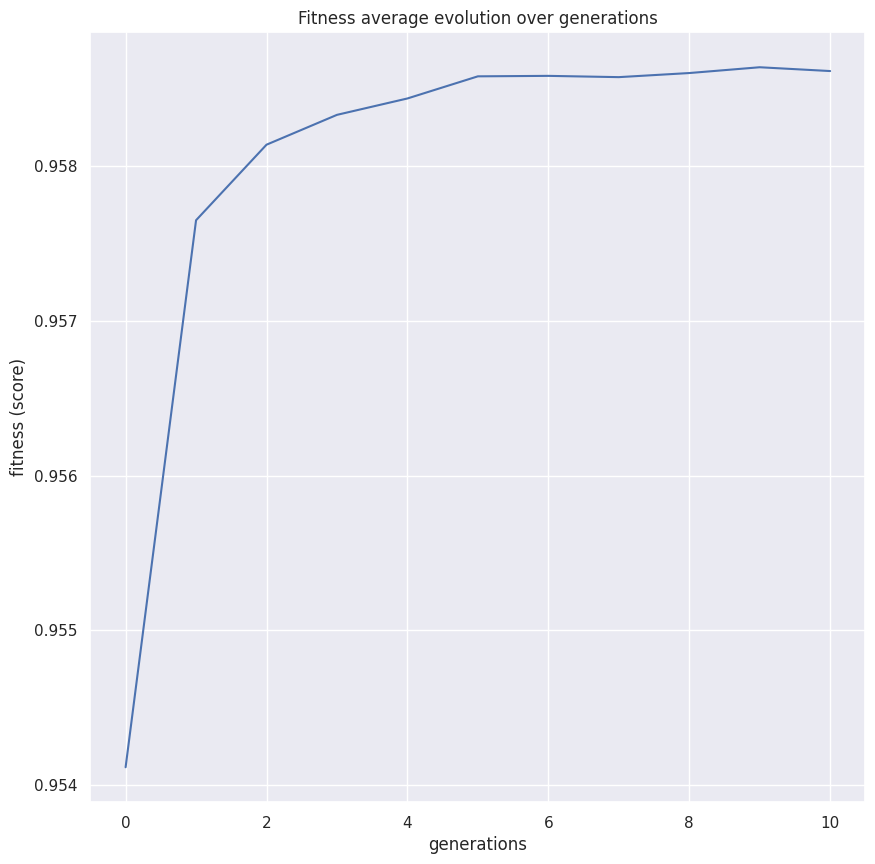

In [27]:
plot_fitness_evolution(evolver_xgb1)

/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your co

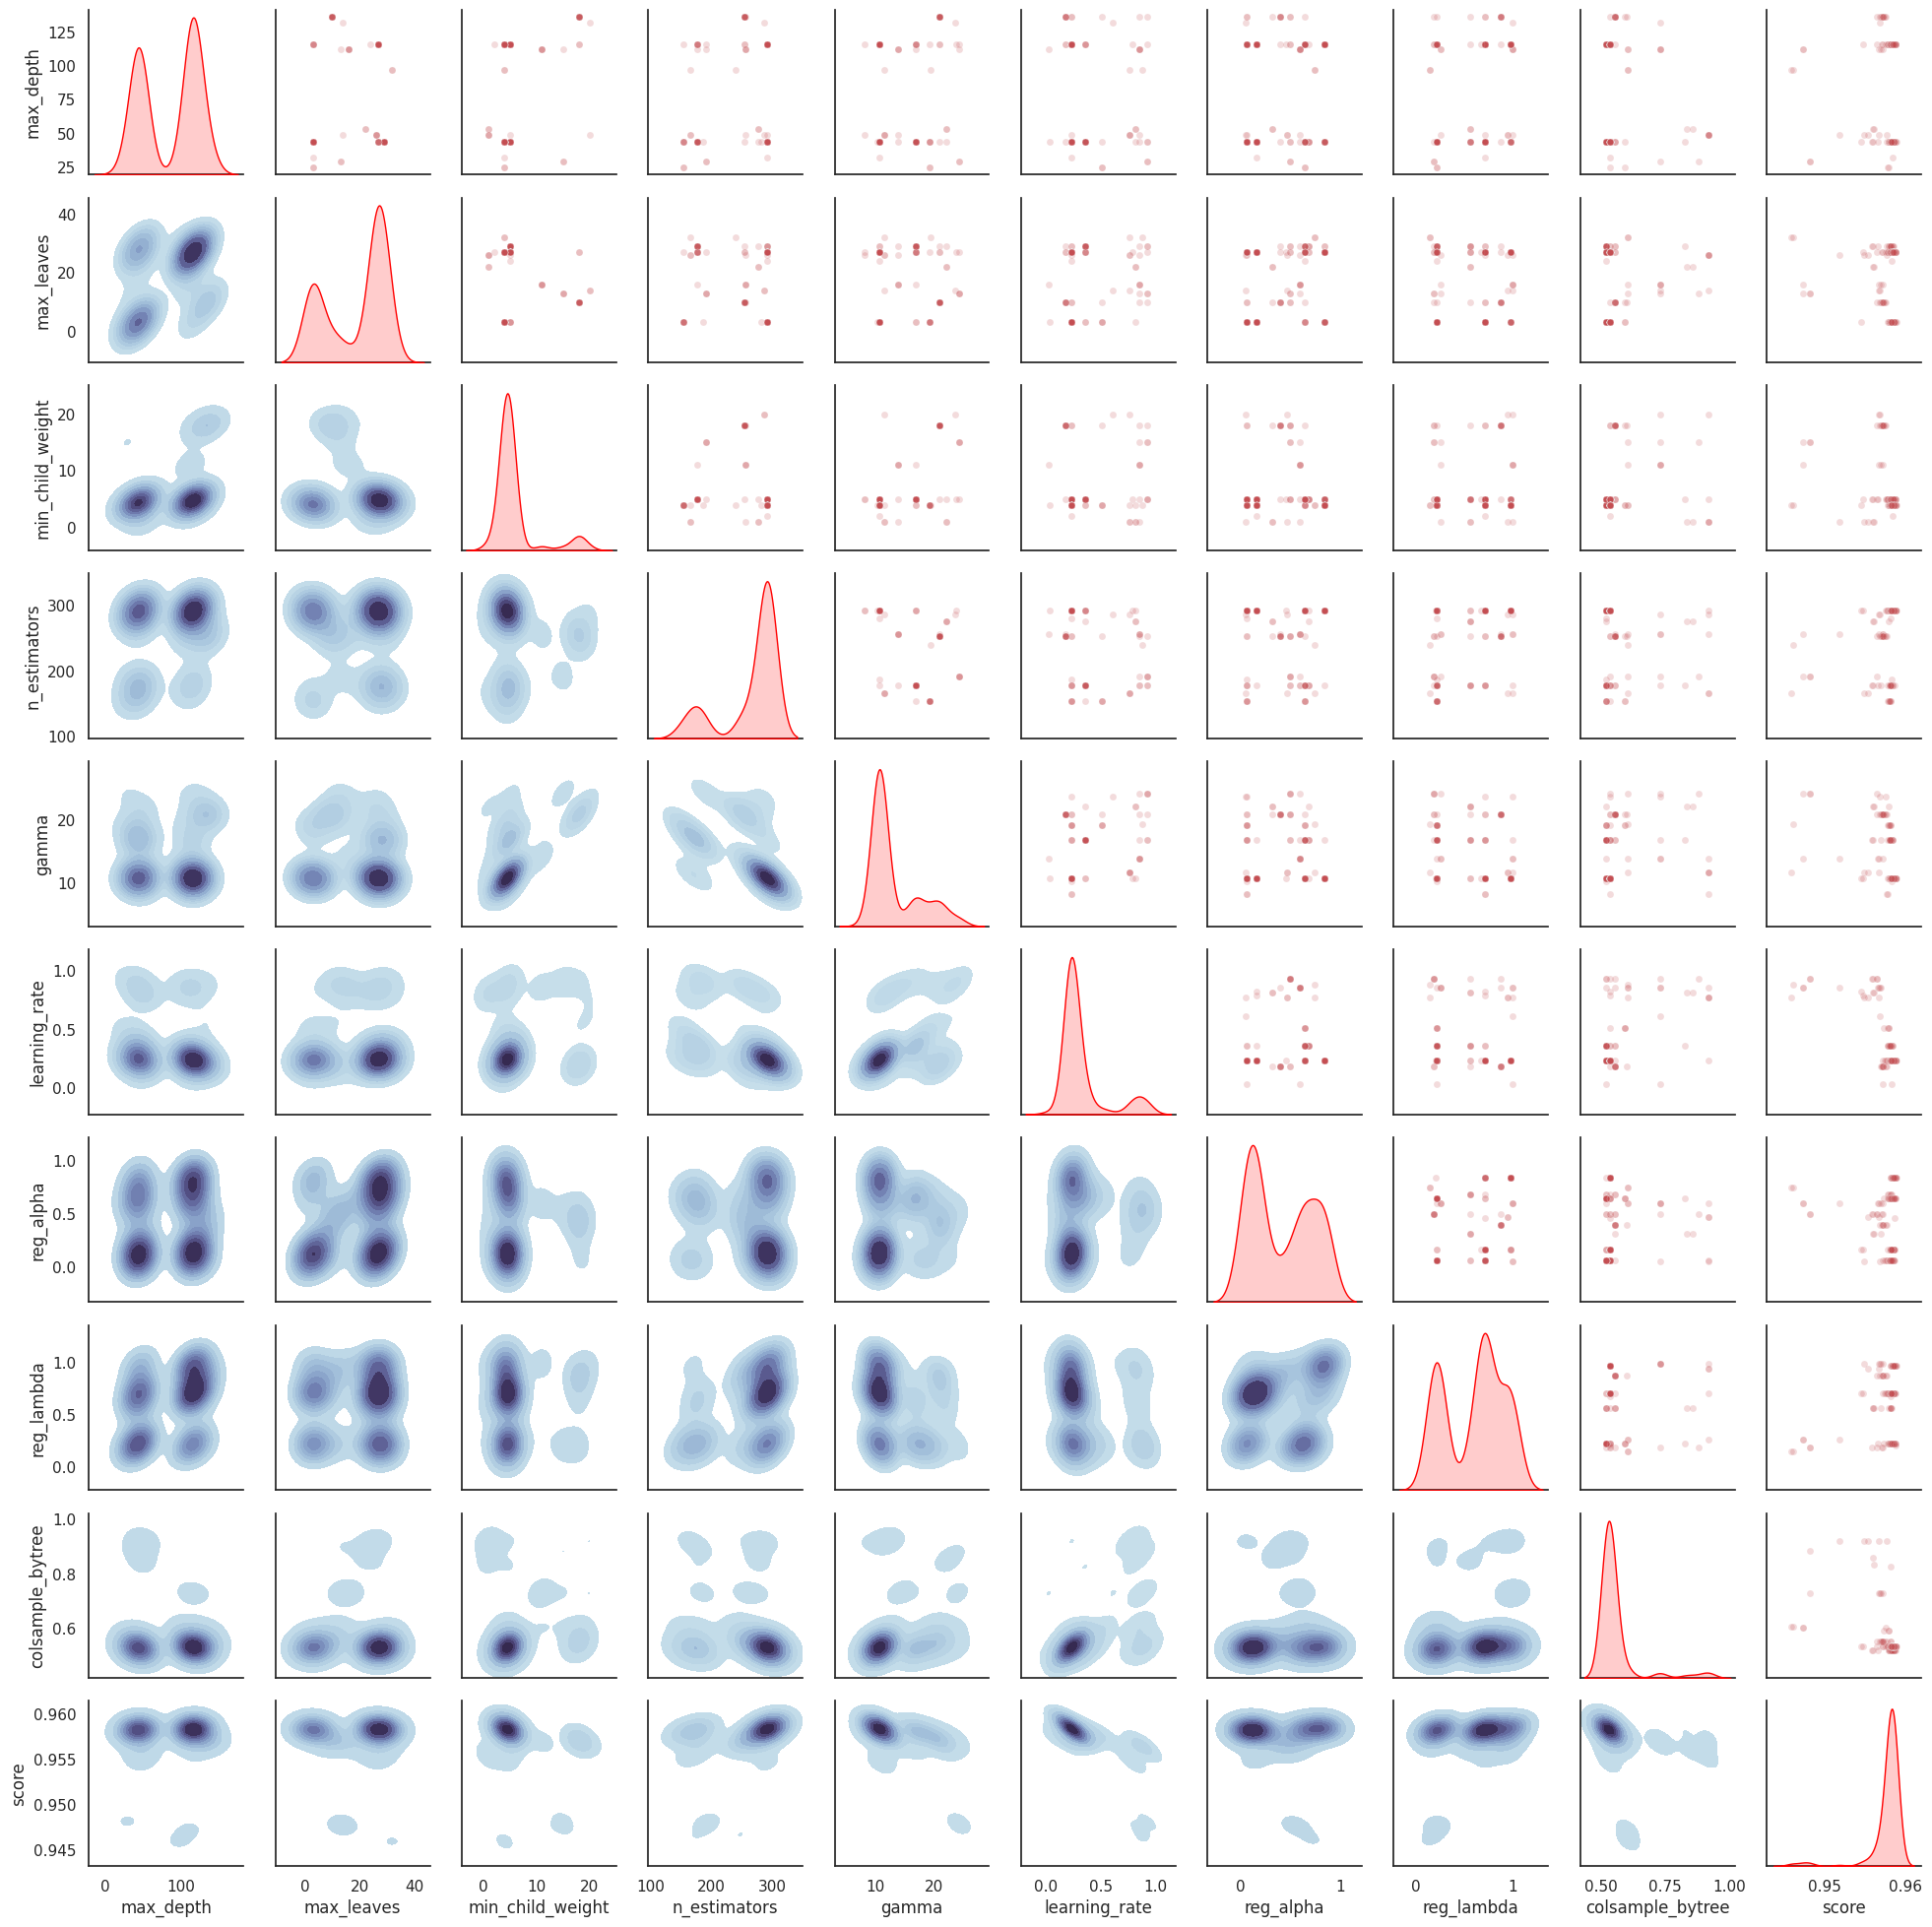

In [30]:
plot_search_space(evolver_xgb1)

/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your co

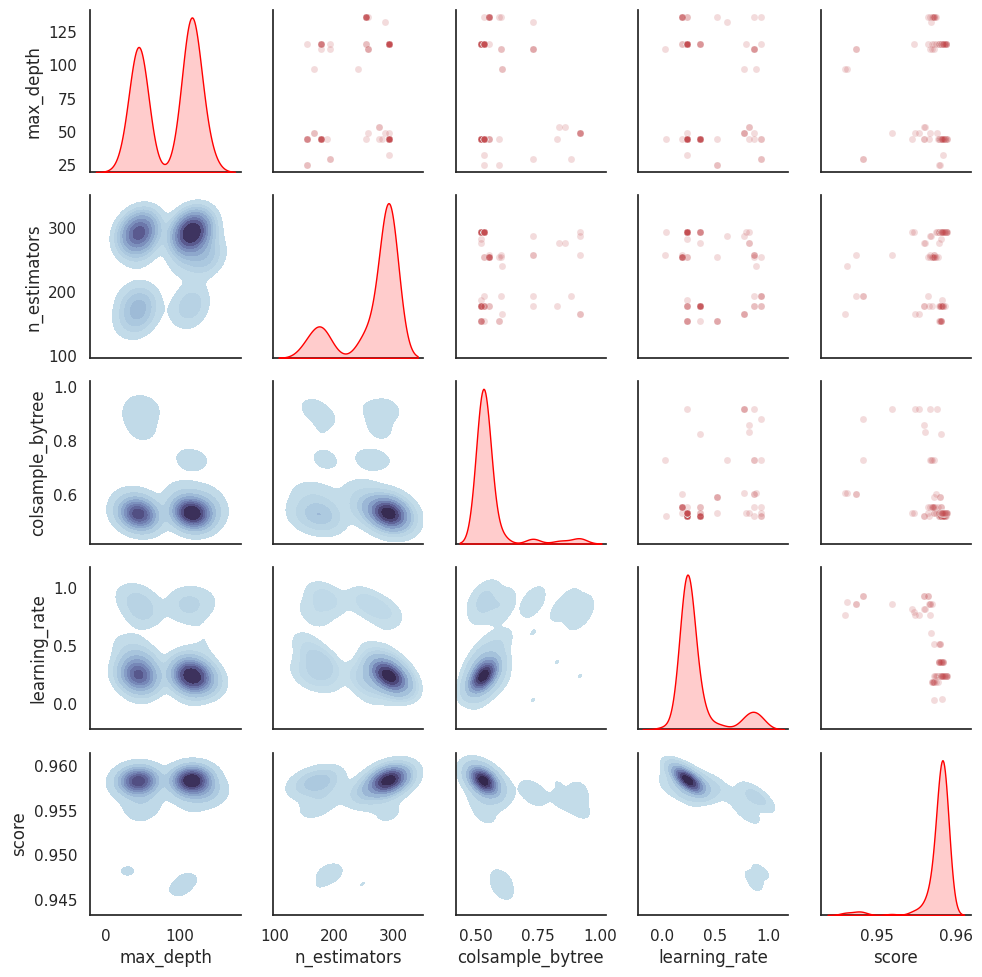

In [33]:
plot_search_space(evolver_xgb1, features = ['max_depth','n_estimators','colsample_bytree','learning_rate','score'])
plt.savefig('evolver_xgb1_space_5_features.png')
plt.show()

/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your co

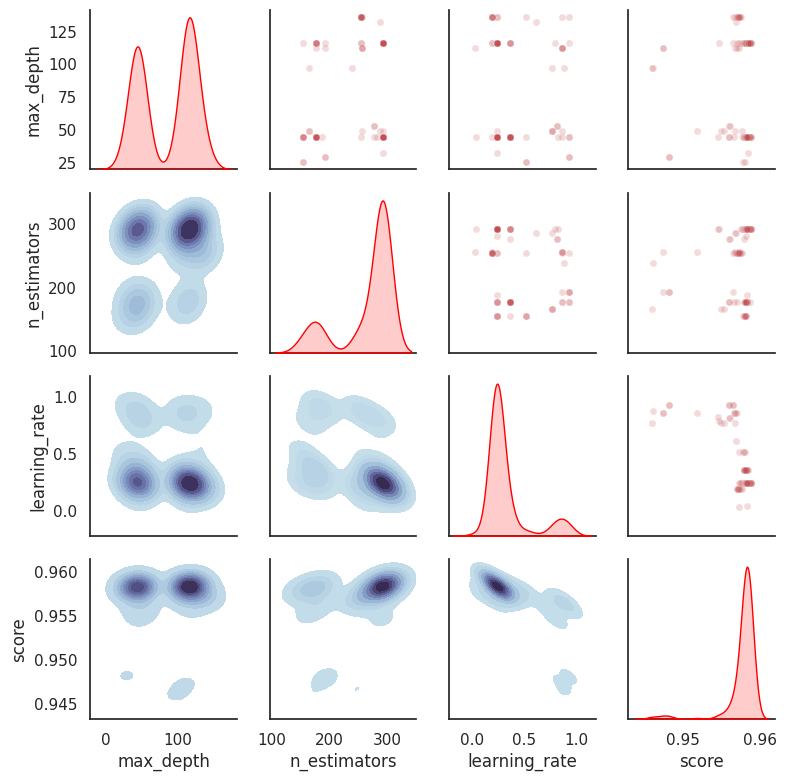

In [34]:
plot_search_space(evolver_xgb1, features = ['max_depth','n_estimators','learning_rate','score'])
plt.savefig('evolver_xgb1_space_4_features.png')
plt.show()

### Combine Hyperparams

In [ ]:
evolver_xgb1.best_params_

{'booster': 'dart',
 'max_depth': 125,
 'max_leaves': 8,
 'min_child_weight': 10,
 'n_estimators': 180,
 'gamma': 11.526289378849375,
 'learning_rate': 0.28113034953333516,
 'reg_alpha': 0.31226867464231967,
 'reg_lambda': 0.4594385456297676,
 'colsample_bytree': 0.9297546855792884}

In [ ]:
evolver_xgb2.best_params_

{'tree_method': 'gpu_hist',
 'scale_pos_weight': 0.8347808150182244,
 'max_depth': 74,
 'max_leaves': 33,
 'min_child_weight': 12,
 'n_estimators': 230,
 'gamma': 10.760334366371987,
 'learning_rate': 0.2443591369209849,
 'reg_alpha': 0.32112497611773394,
 'reg_lambda': 0.46742053311022985,
 'colsample_bytree': 0.8414378980220896}

In [ ]:
combo_opt_params_xgb = {**evolver_xgb2.best_params_, **evolver_xgb1.best_params_}
combo_opt_params_xgb

{'tree_method': 'gpu_hist',
 'scale_pos_weight': 0.8347808150182244,
 'max_depth': 125,
 'max_leaves': 8,
 'min_child_weight': 10,
 'n_estimators': 180,
 'gamma': 11.526289378849375,
 'learning_rate': 0.28113034953333516,
 'reg_alpha': 0.31226867464231967,
 'reg_lambda': 0.4594385456297676,
 'colsample_bytree': 0.9297546855792884,
 'booster': 'dart'}

In [ ]:
xgb_opt_combo = xgb.XGBClassifier(**combo_opt_params_xgb)

In [ ]:
xgb_opt_combo.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9297546855792884, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=11.526289378849375, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.28113034953333516, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=125, max_leaves=8,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=180, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
preds_xgb_combo = xgb_opt_combo.predict(X_val)

In [ ]:
f1_score(y_val, preds_xgb_combo)

0.9560843991149965

### Final evaluation

In [40]:
ce_xgb_gene_opt1 = ClassEvaluation(X_heldout, y_heldout, xgb_opt1)
ce_xgb_gene_opt1.full_test

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid,prediction
636195,2,184492194,63.3,61,39,0,39,1.000000,63,64,0,0,True,1
1966339,7,416005,50.3,50,40,17,23,0.575000,50,0,60,0,True,1
656428,2,197902408,38.4,38,38,14,24,0.631579,38,0,55,0,True,1
1624000,5,154128276,49.3,48,36,14,22,0.611111,49,0,55,0,True,1
3845440,16,4769495,58.2,55,42,0,42,1.000000,58,57,0,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016450,3,181927308,58.9,56,34,0,34,1.000000,58,59,0,0,True,1
2413432,8,111119591,47.3,46,32,9,23,0.718750,47,0,52,0,True,1
233060,1,167087706,63.2,61,53,0,53,1.000000,63,66,0,0,True,1
1305795,4,153681058,47.5,46,26,0,26,1.000000,47,52,0,0,True,1


In [41]:
ce_xgb_gene_opt1.calculate_metrics()

{'f1_score_full': 0.9666, 'precision_full': 0.953, 'recall_full': 0.9805}

## Random Forest

In [1]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Categorical, Integer
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

2023-06-05 22:42:35.237798: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-05 22:42:35.562910: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-05 22:42:36.594711: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
cv = StratifiedKFold(n_splits=3, shuffle=True)

In [3]:
param_grid = {'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
              'bootstrap': Categorical([True, False]),
              'max_depth': Integer(2, 30), 
              'max_leaf_nodes': Integer(2, 35), 
              'n_estimators': Integer(100, 300)}

In [4]:
gene_forest = RandomForestClassifier()

In [5]:
sklearn.metrics.get_scorer_names()[:5]

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy']

In [25]:
evolved_estimator = GASearchCV(estimator=gene_forest,
                               cv=cv,
                               scoring='f1',
                               population_size=10,
                               generations=35,
                               tournament_size=3,
                               elitism=True,
                               crossover_probability=0.8,
                               mutation_probability=0.1,
                               param_grid=param_grid,
                               criteria='max',
                               algorithm='eaMuPlusLambda',
                               n_jobs=-1,
                               verbose=True,
                               keep_top_k=4)

In [26]:
evolved_estimator.fit(X_train_5, y_train_5)

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	10    	0.943587	0.0089013  	0.951583   	0.92704    
4  	17    	0.951501	5.90403e-05	0.951583   	0.951394   
5  	17    	0.951541	6.62645e-05	0.95161    	0.951438   
6  	14    	0.951597	1.81033e-05	0.951621   	0.951569   
7  	19    	0.951588	3.60368e-05	0.95161    	0.951489   


/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


8  	18    	0.951595	1.55085e-05	0.95161    	0.95157    
9  	19    	0.951595	2.80447e-05	0.95161    	0.951518   
10 	19    	0.951632	0.000120112	0.951936   	0.951457   
11 	17    	0.951689	0.000108455	0.951936   	0.95161    
12 	19    	0.951761	0.000132593	0.951917   	0.95161    
13 	20    	0.951867	0.000119166	0.951985   	0.951541   
14 	17    	0.951952	5.37753e-05	0.952071   	0.951899   
15 	18    	0.951992	6.22974e-05	0.952071   	0.951823   
16 	18    	0.952004	3.06307e-05	0.952029   	0.951926   
17 	20    	0.951999	4.11816e-05	0.952029   	0.951889   
18 	19    	0.951976	4.82652e-05	0.952029   	0.951875   
19 	16    	0.952005	2.03839e-05	0.952029   	0.951984   
20 	18    	0.952001	1.8935e-05 	0.952029   	0.951983   
21 	19    	0.951986	3.84243e-05	0.952029   	0.951901   
22 	18    	0.951961	4.12237e-05	0.952029   	0.951877   
23 	17    	0.95197 	4.35931e-05	0.952029   	0.951854   
24 	20    	0.951957	2.64217e-05	0.951988   	0.951917   
25 	18    	0.951931	4.77085e-05	0.951984   	0.95

/home/skomlev/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


26 	19    	0.951935	3.36575e-05	0.951984   	0.951893   
27 	18    	0.951924	4.40003e-05	0.951979   	0.951842   
28 	18    	0.951936	4.94607e-05	0.951991   	0.951845   
29 	19    	0.951958	5.14702e-05	0.95201    	0.95183    
30 	18    	0.951989	3.37072e-05	0.952067   	0.951938   
31 	18    	0.951974	4.91201e-05	0.95201    	0.951837   
32 	19    	0.951997	8.74956e-06	0.95201    	0.951986   
33 	17    	0.951999	1.24053e-05	0.95201    	0.951971   
34 	18    	0.951983	3.53862e-05	0.95201    	0.95188    
35 	19    	0.951982	3.00085e-05	0.95201    	0.951899   


GASearchCV(crossover_probability=0.8,
           cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
           estimator=RandomForestClassifier(max_depth=28, max_leaf_nodes=24,
                                            min_weight_fraction_leaf=0.010569570798655002,
                                            n_estimators=256),
           generations=35, keep_top_k=4, mutation_probability=0.1, n_jobs=-1,
           param_grid={'bootstrap': <sklearn_genetic.space.space.Categor...
                       'max_depth': <sklearn_genetic.space.space.Integer object at 0x7fbc90436730>,
                       'max_leaf_nodes': <sklearn_genetic.space.space.Integer object at 0x7fbae4621400>,
                       'min_weight_fraction_leaf': <sklearn_genetic.space.space.Continuous object at 0x7fbc925275b0>,
                       'n_estimators': <sklearn_genetic.space.space.Integer object at 0x7fbadf679bb0>},
           population_size=10, return_train_score=True, scoring='f1')

In [27]:
#evolved_estimator.logbook

In [28]:
evolved_estimator.best_params_

{'min_weight_fraction_leaf': 0.010569570798655002,
 'bootstrap': True,
 'max_depth': 28,
 'max_leaf_nodes': 24,
 'n_estimators': 256}

In [29]:
evolved_estimator.best_estimator_

RandomForestClassifier(max_depth=28, max_leaf_nodes=24,
                       min_weight_fraction_leaf=0.010569570798655002,
                       n_estimators=256)

In [ ]:
evolved_estimator.best_score_

0.9525915774405135

In [ ]:
evolved_estimator.hof

{0: {'min_weight_fraction_leaf': 0.011395458553953183,
  'bootstrap': True,
  'max_depth': 29,
  'max_leaf_nodes': 21,
  'n_estimators': 253},
 1: {'min_weight_fraction_leaf': 0.015052791256335487,
  'bootstrap': True,
  'max_depth': 29,
  'max_leaf_nodes': 21,
  'n_estimators': 254},
 2: {'min_weight_fraction_leaf': 0.015052791256335487,
  'bootstrap': True,
  'max_depth': 29,
  'max_leaf_nodes': 21,
  'n_estimators': 253},
 3: {'min_weight_fraction_leaf': 0.015052791256335487,
  'bootstrap': True,
  'max_depth': 22,
  'max_leaf_nodes': 21,
  'n_estimators': 253}}

In [ ]:
preds_gene_forest = evolved_estimator.predict(X_test)

In [ ]:
f1_score(y_test, preds_gene_forest)

0.9532355252816348

### Save Model

In [ ]:
import pickle

filename = 'evolved_estimator_1.sav'
pickle.dump(evolved_estimator, open(filename, 'wb'))

In [ ]:
import joblib

#save your model or results
#joblib.dump(evolved_estimator, 'evolved_estimator.pkl')

#load your model for further usage
joblib.load("model_file_name.pkl")

### Visualization

/home/skomlev/.local/lib/python3.8/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


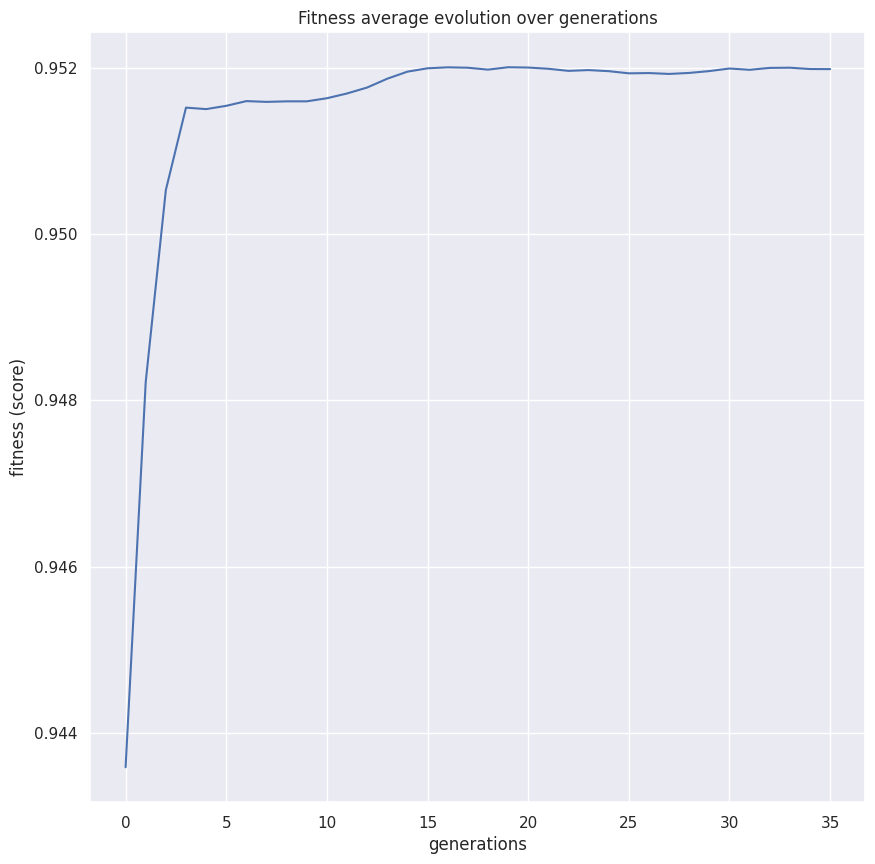

In [32]:
plot_fitness_evolution(evolved_estimator)
plt.savefig('evolved_forest1_fitness.png')
plt.show()

/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/home/skomlev/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:1507: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your co

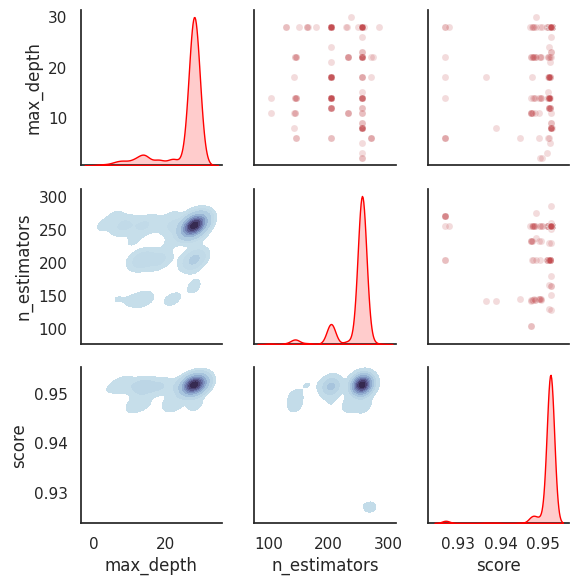

In [35]:
plot_search_space(evolved_estimator, features = ['max_depth','n_estimators','score'])
plt.savefig('evolved_forest1_space_3_features.png')
plt.show()

# Hyperopt Bayesian* Optimization

source: https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9

## Preparations

In [12]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
evolver_xgb1.best_params_

NameError: name 'evolver_xgb1' is not defined

In [ ]:
xgb_bayes_space1 = {
    'max_depth': hp.quniform("max_depth", 100, 150, 2),
    'max_leaves': hp.quniform("max_leaves", 5, 15, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 5, 20, 2),
    'n_estimators': hp.quniform('n_estimators',150, 230, 4),
        
    'gamma': hp.uniform ('gamma', 7, 20),
    'learning_rate': hp.uniform('learning_rate', 0.15, 0.5),
    'reg_alpha' : hp.uniform('reg_alpha', 0.15, 0.45),
    'reg_lambda' : hp.uniform('reg_lambda', 0.25, 0.6),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.8, 1)
}

In [ ]:
# Classifier:
def bayes_tuning(space):
    model = xgb.XGBClassifier(n_jobs = 50, booster = 'dart',
                              
                              max_depth = int(space['max_depth']),
                              max_leaves = int(space['max_leaves']),
                              min_child_weight=int(space['min_child_weight']),
                              n_estimators = int(space['n_estimators']),
                              
                              gamma = space['gamma'],
                              learning_rate = space['learning_rate'],
                              reg_alpha = space['reg_alpha'],
                              reg_lambda = space['reg_alpha'],
                              colsample_bytree=space['colsample_bytree'])

    #evaluation = [( x_train, y_train), ( x_val, y_val)]
    
    model.fit(X_train_5, y_train_5)#, eval_set=evaluation, eval_metric="auc",early_stopping_rounds=10,verbose=False)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds)
    
    print("F1-score:", f1)
    print('Params:', {k: v for k, v in model.get_xgb_params().items() if v is not None})
    print('===========================================================================')
    
    return {'loss': -f1, 'status': STATUS_OK, 'model': model}

## Hyperopt Search

In [ ]:
trials = Trials()
best_bayes = fmin(fn=bayes_tuning,
            space=xgb_bayes_space1,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print(best_bayes)

F1-score:                                                                                                                                                          
0.958896456425781                                                                                                                                                  
Params:                                                                                                                                                            
{'objective': 'binary:logistic', 'booster': 'dart', 'colsample_bytree': 0.8409230968549377, 'gamma': 15.218481148619523, 'learning_rate': 0.31767272069251096, 'max_depth': 140, 'max_leaves': 13, 'min_child_weight': 6, 'n_jobs': 50, 'reg_alpha': 0.3423326927101763, 'reg_lambda': 0.3423326927101763}
F1-score:                                                                                                                                                          
0.9587214247982284                           

## Results analysis

In [13]:
xgb_bayes_params1 = {'booster': 'dart','colsample_bytree': 0.8142662131040501, 'gamma': 9.40085205546059, 'learning_rate': 0.15311629478828515, 
                     'max_depth': 146, 'max_leaves': 13, 'min_child_weight': 6, 'n_estimators': 172, 
                     'reg_alpha': 0.3738212572973302, 'reg_lambda': 0.543917511593457}

In [14]:
len(xgb_bayes_params1)

10

In [15]:
xgb_bayes1 = xgb.XGBClassifier(**xgb_bayes_params1, n_jobs=60)
xgb_bayes1

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8142662131040501, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9.40085205546059, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15311629478828515, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=146, max_leaves=13,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=172, n_jobs=60, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
xgb_bayes1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8142662131040501, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=9.40085205546059, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.15311629478828515, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=146, max_leaves=13,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=172, n_jobs=60, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
#save_model(xgb_bayes1, 'xgb_bayes1.sav')

In [23]:
ce_xgb_bayes1 = ClassEvaluation(X_heldout, y_heldout, xgb_bayes1)
ce_xgb_bayes1.full_test

,CHROM_num,POS,QUAL,GQ,DP,AD_ref,AD_alt,VAF,PL_0/0,PL_0/1,PL_1/1,ref_alt_diff,is_valid,prediction
636195,2,184492194,63.3,61,39,0,39,1.000000,63,64,0,0,True,1
1966339,7,416005,50.3,50,40,17,23,0.575000,50,0,60,0,True,1
656428,2,197902408,38.4,38,38,14,24,0.631579,38,0,55,0,True,1
1624000,5,154128276,49.3,48,36,14,22,0.611111,49,0,55,0,True,1
3845440,16,4769495,58.2,55,42,0,42,1.000000,58,57,0,0,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016450,3,181927308,58.9,56,34,0,34,1.000000,58,59,0,0,True,1
2413432,8,111119591,47.3,46,32,9,23,0.718750,47,0,52,0,True,1
233060,1,167087706,63.2,61,53,0,53,1.000000,63,66,0,0,True,1
1305795,4,153681058,47.5,46,26,0,26,1.000000,47,52,0,0,True,1


In [24]:
ce_xgb_bayes1.calculate_metrics()

{'f1_score_full': 0.966, 'precision_full': 0.9521, 'recall_full': 0.9802}